In [30]:
import copy
import os
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim, cont2discrete,butter,filtfilt
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import pickle
import control as ct
import cvxpy as cp
import seaborn as sns
import pandas as pd

## Functions for running BOP-DMD training and testing

In [2]:
def bopdmd_train_test(svd_rank,num_trials,training_set,training_voltage,test_voltage,train_time,test_time,Btilde,return_training_fit, 
                     conjugate_bool, stable_bool, noise_level, evaluate,C,D):
    optdmd = BOPDMD(svd_rank = svd_rank, compute_A = True) #make our opt and bop objects with the correct
                                                            #number of trials and svd rank
        
        # Decide if we want to enforce that the models have eigenvalues that come in complex conjugate pairs, and 
        # enforce stability
    if conjugate_bool == True and stable_bool == True:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
    elif conjugate_bool == True and stable_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'conjugate_pairs'})
    elif stable_bool == True and conjugate_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable'})
    else:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True)
    
#     rmse = mean_squared_error(training_set[:, 1], np.zeros(training_set[:, 1].shape), squared=False)
    training_set_func = training_set + np.random.normal(0,  (np.sqrt(np.mean(training_set**2))/ 100.0) * noise_level, training_set.shape)
    bopdmd.fit(training_set_func,train_time) #fit out data
    
    Atilde = bopdmd.A #get A matrix from bop
    
    
    
    #now we are going to see how well bop does on our test voltages. These will simulate a vacuum shot and
    #be a series of 3 state square waves that are fed into each of the four circuits
    if evaluate == True:
        tout,yout,xout = lsim((Atilde,Btilde,C,D),test_voltage,test_time)
    
        return Atilde,bopdmd,xout
    else:
        return Atilde,bopdmd
    
    if return_training_fit == True:
        tout_train,yout_train,xout_train = lsim((Atilde,Btilde,C,D),train_voltage,time)
        return xout_train
    

## Import BOP-DMD model for the flux circuits in vacuum, and import analytic state space model for flux circuits in plasma and in vacuum

In [3]:
filename = 'continuous_vacuum_ss_model'
with open(filename,'rb') as file:
    sysc = pickle.load(file)
    print(f'object successfully saved to {filename}')
A = sysc.A
B = sysc.B
C = sysc.C
D = sysc.D

print(np.shape(A))

A_plasma = loadmat('plasma_ss_A_matrix').get('A')

print(np.shape(A_plasma))

B_plasma = np.vstack((B,np.zeros((1,4))))
C_plasma = np.hstack((C,np.zeros((4,1))))

bop_A_vacuum = loadmat('BOP_A_matrix.mat').get('matrix')

print(np.shape(bop_A_vacuum))

object successfully saved to continuous_vacuum_ss_model
(12, 12)
(13, 13)
(12, 12)


## Function to load in a vacuum shot

In [4]:
def load_vacuum_shot(directory, flux): #Pass in a directory as a string, and this function will cycle through the whole directory 
                             
        #If flux = False, will load the voltage circuits
        
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []
    
    if flux == True:

        state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
        state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
    
    else:
        state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4']
        state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))




    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list, experiment_time




In [5]:
def make_graph(data,title,legend,impulse): #data should be a list of what one wants plotted,title is a string,
                                  #legend is an array of strings,impulse is a boolean if one is plotting the ringdown of a shot



    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey = 'row', figsize=(20, 15))
    fig.tight_layout()
    fig.text(0.5, -0.04, 'Time (ms)', ha='center', fontsize = 20)
    fig.text(-0.04, 0.175, 'Flux Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.5, 'Capacitor Voltage (V)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.825, 'Series Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(.5,1.04,title,ha = 'center',fontsize = 40)
    
    if impulse == False:
        plt.xlim([0,4])
        time = experiment_time[251::]
    else:
        time = experiment_time[1772::]
    L1 = [0,3,6,9]
    C = [1,4,7,10]
    L2 = [2,5,8,11]
    
    colors = ['r','k']
    alphas = [1,.6]
    for i in range(len(L1)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+1)
            plt.plot(1000*time,np.real(j[:,L1[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()


    for i in range(len(C)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+5)
            plt.plot(1000*time,np.real(j[:,C[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()

    for i in range(len(L2)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+9)
            plt.plot(1000*time,np.real(j[:,L2[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()



    fig.legend(legend, fontsize = 15)
    


In [6]:
def load_plasma_shot(directory): #Pass in a directory as a string, and this function will cycle through the whole directory 

#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4','i_tor']
    state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))



    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list




In [7]:
flux_trajectory_list,flux_inputs_list,flux_state_deriv_list,experiment_time = load_vacuum_shot('data/plasma_shots/flux_data/220816009',flux = True)
voltage_trajectory_list,voltage_inputs_list,voltage_state_deriv_list = load_plasma_shot('data/plasma_shots/220816009')
print(len(flux_trajectory_list))
print(len(voltage_trajectory_list))

voltage_trajectory_vacuum,voltage_inputs_vacuum,state_deriv_list,experiment_time = load_vacuum_shot('data/vacuum_shots_220816/good_shots/voltage_data',flux = False)

1
1


## Below is a simulation of what an analytic linear model of the flux circuits look like when a plasma is present. 

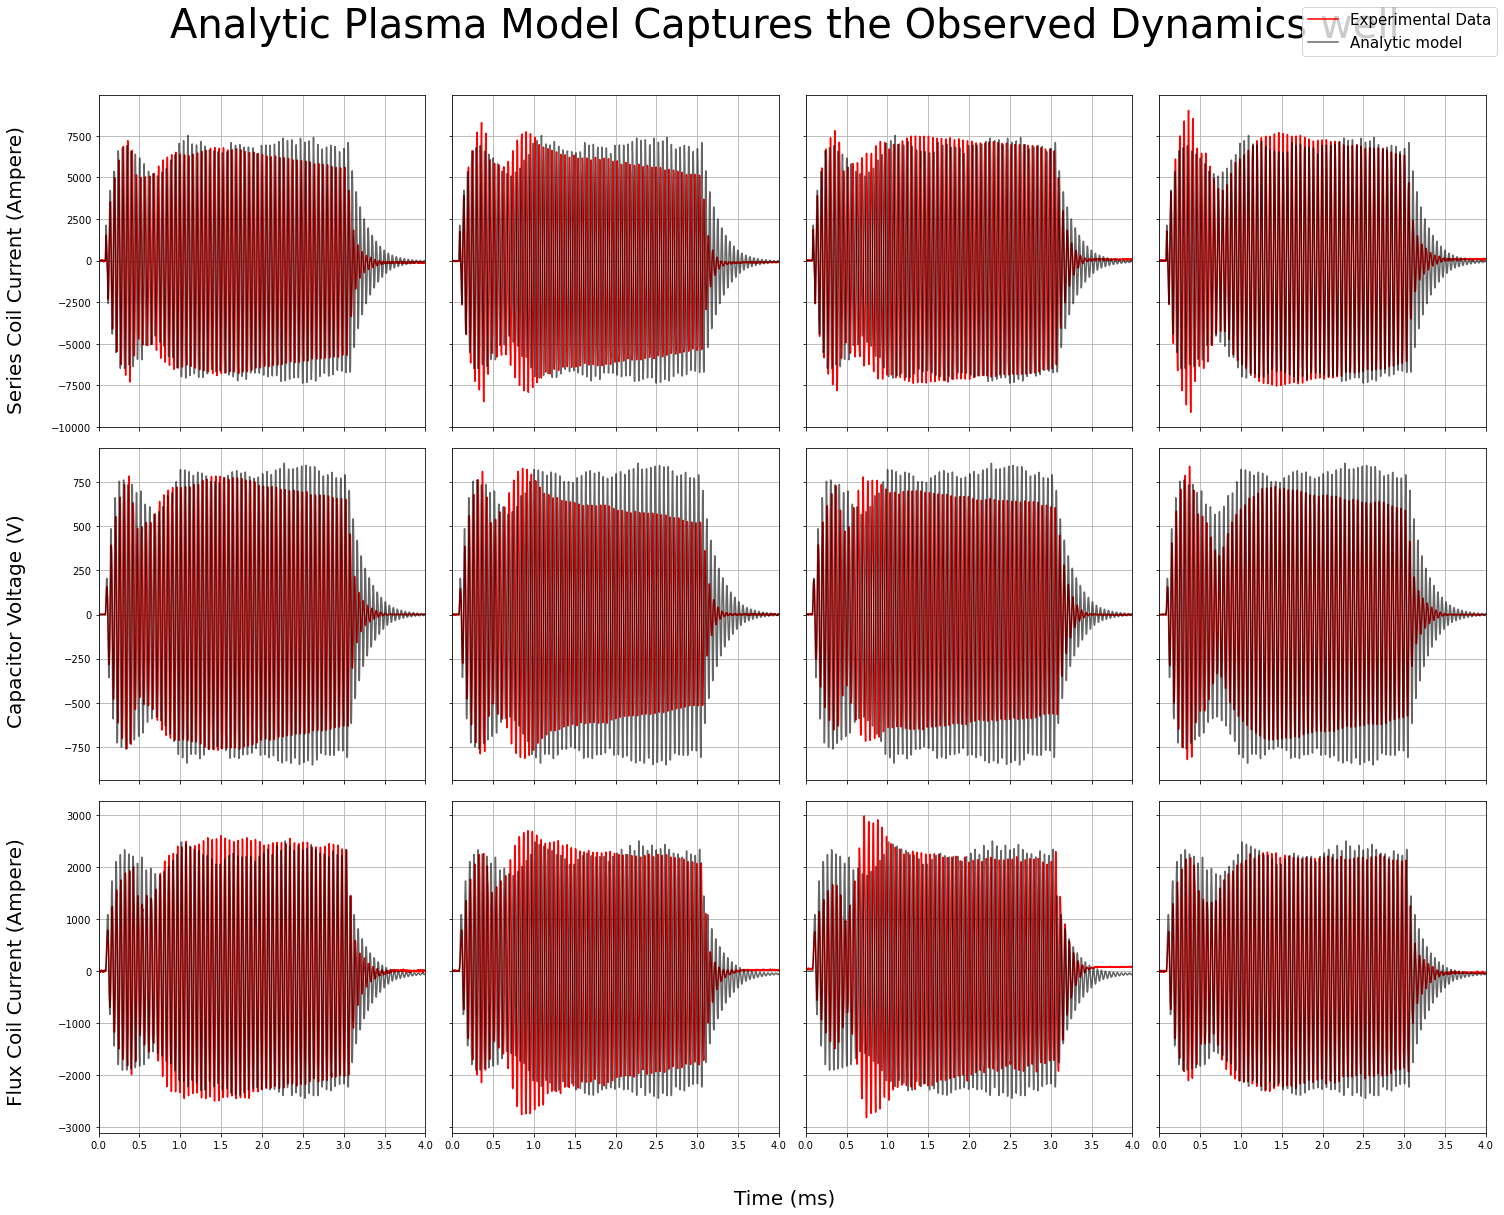

In [8]:
tout,yout,xout_plasma_ss = lsim((A_plasma,B_plasma,C_plasma,D),flux_inputs_list[0][251::,:],experiment_time[251::])
# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(xout_plasma_ss[:,i])
#     plt.plot(flux_trajectory_list[0][251::,i])
#     plt.legend(['Analytic Plasma model','Real plasma shot'])

make_graph( [ flux_trajectory_list[0][251::,:],xout_plasma_ss ], 'Analytic Plasma Model Captures the Observed Dynamics well',['Experimental Data','Analytic model'],impulse = False ) 

## Remove any DC offset or measurment errors from the experimental data

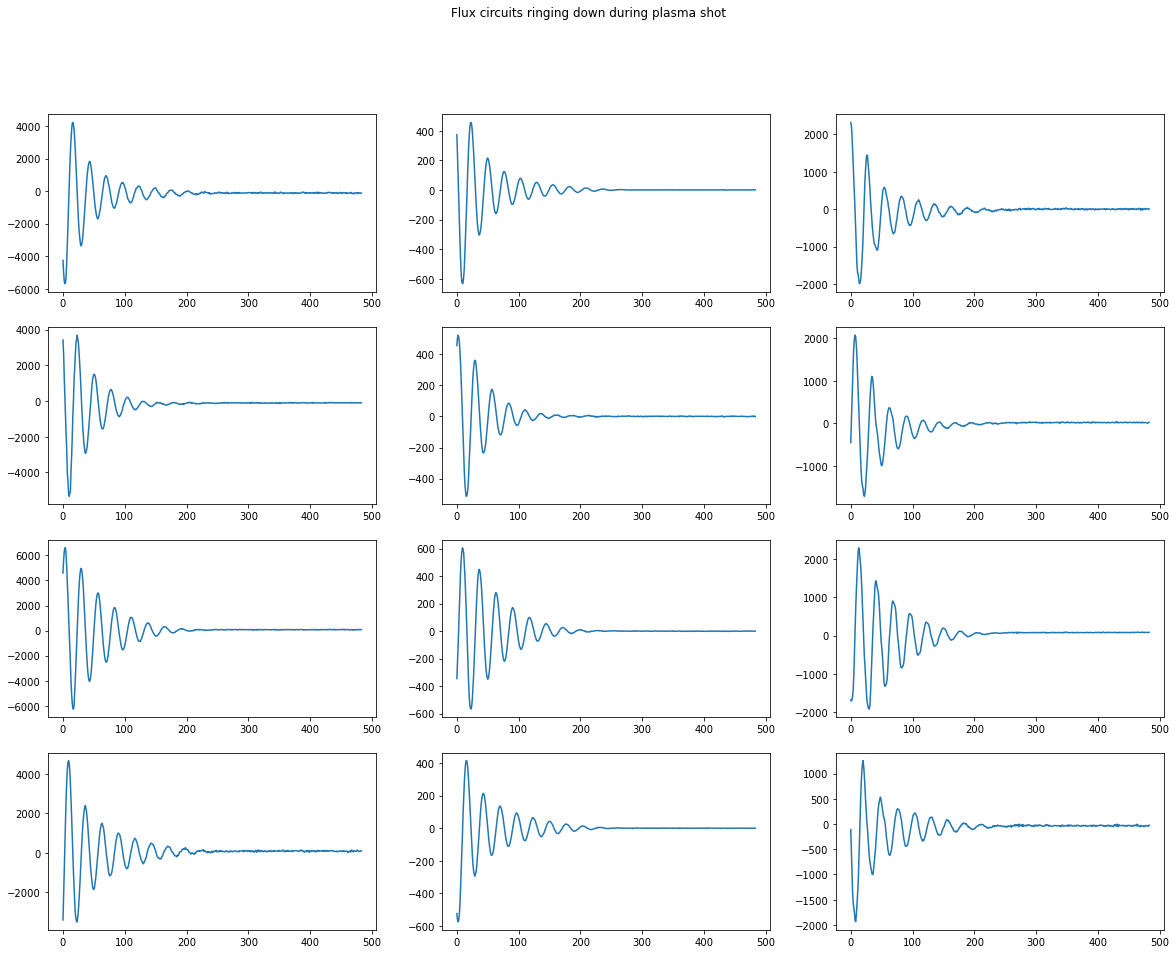

In [9]:
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(flux_trajectory_list[0][1772::,i])
    plt.suptitle('Flux circuits ringing down during plasma shot')

In [10]:
print(np.shape(voltage_trajectory_list[0][:,12]))

#Add on itor to the flux trajectory list
flux_trajectory_list[0] = np.hstack((flux_trajectory_list[0],voltage_trajectory_list[0][:,12].reshape(len(experiment_time),1)))

print(np.shape(flux_trajectory_list[0]))

(2256,)
(2256, 13)


## BOP on Flux circuits during a plasma shot. We train on just the ring down as it's when the effect of the power supplies is the least present

In [11]:
# We train BOP-DMD on the last ~480 samples of a shot, take the A matrix generated by BOP-DMD, stuff that into a 
# continuous time system, and simulate the system with the power supply waveforms that generated the shot. We then compare the 
#ground truth and the BOP-DMD prediction

Atilde_flux_list = []
bop_obj_flux_list = []
xout_flux_list = []
for i in range(30): #number of modes we want to fit.
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = flux_trajectory_list[0].T[0:13,1772::], 
        training_voltage = flux_inputs_list[0][1772::,:],
        test_voltage = flux_inputs_list[0][251::,:],
            train_time = experiment_time[1772::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = np.vstack((B,np.zeros((1,4)))),
        C = np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    Atilde_flux_list.append(Atilde) #Each A matrix generated by BOP-DMD
    bop_obj_flux_list.append(bop_obj) # Each BOP-DMD object
    xout_flux_list.append(xout) #Test data for each fit. 


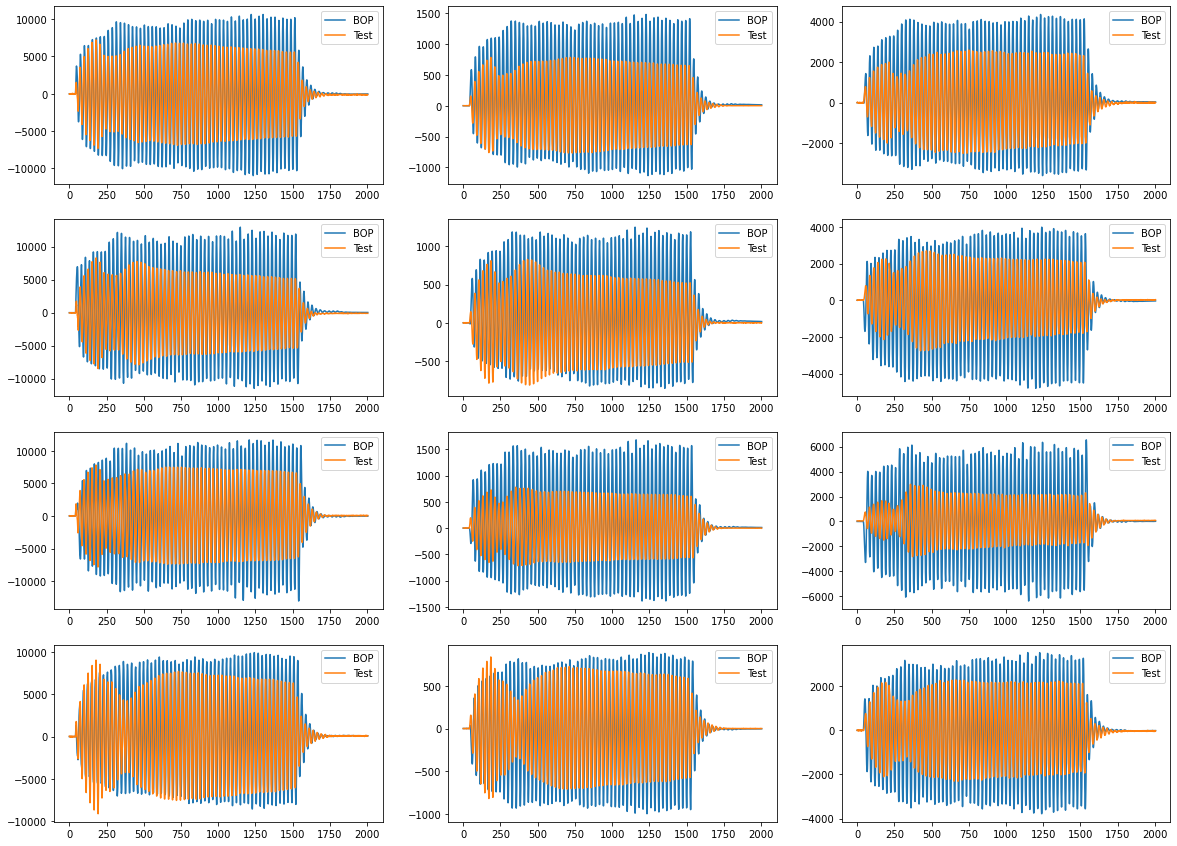

In [12]:
num = 7 # number of modes that are included in the model. num = modes - 1


#8


plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_flux_list[num][::,i]))
    plt.plot(flux_trajectory_list[0][251::,i])
    plt.legend(['BOP','Test'])

## Let's take a look at the eigenvalues for the DMD model vs. The Plasma model

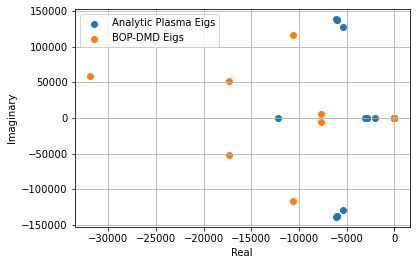

In [13]:
plt.figure()
plt.scatter(np.linalg.eigvals(A_plasma).real,np.linalg.eigvals(A_plasma).imag)
#Eigenvalues on whatever number of modes is plotted above
plt.scatter(np.linalg.eigvals(Atilde_flux_list[num]).real,np.linalg.eigvals(Atilde_flux_list[num]).imag) 
plt.legend(['Analytic Plasma Eigs','BOP-DMD Eigs'])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()

## We try 'post fitting' by projecting a point in the time series onto the DMD modes below

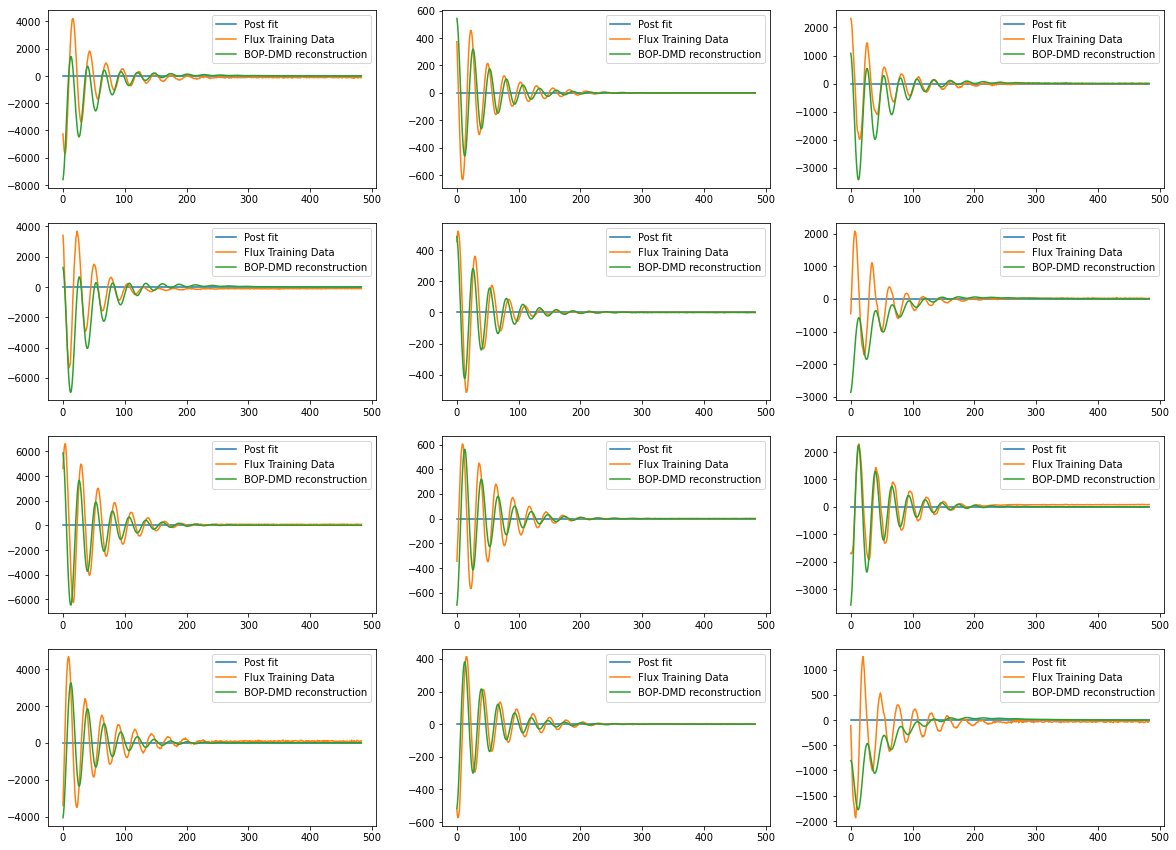

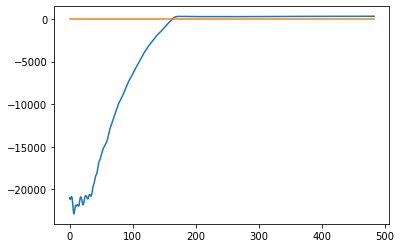

In [14]:
# plt.plot(bop_obj_list[num].dynamics.real.T/bop_obj_list[num].amplitudes)

# print(np.shape(bop_obj_list[num].dynamics.T))

# print(np.shape(bop_obj_list[num].modes))
num = 7

b = flux_trajectory_list[0][100,:].T@bop_obj_flux_list[num].modes

# print(np.abs(b))

bop_state_recon = (bop_obj_flux_list[num].dynamics.real.T )@bop_obj_flux_list[num].modes.T
state = np.zeros(np.shape(flux_trajectory_list[0][1772::,:]))

z_star = np.exp([i*experiment_time[1772::] for i in bop_obj_flux_list[num].eigs])
z_star = [z_star[i,:]*b[i] for i in range(len(b))]

z_tilde = bop_obj_flux_list[num].modes @ z_star


# print(bop_obj_list[num].amplitudes)
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(z_tilde[i,:]))
#     plt.plot(np.real(bop_state_recon[:,i]))
    plt.plot(flux_trajectory_list[0][1772::,i])
    plt.plot(bop_state_recon[:,i].real)
    plt.legend(['Post fit','Flux Training Data','BOP-DMD reconstruction'])
#     plt.plot((bop_obj_list[num].dynamics.T / bop_obj_list[num].amplitudes)@bop_obj_list[num].modes.T)

plt.figure()
plt.plot(flux_trajectory_list[0][1772::,12])
plt.plot(np.real(z_tilde[12,:]))
# plt.plot(bop_state_recon)

# print(b)
# print(bop_obj_list[num].amplitudes)



## Let's see how well the vacuum model actually fits the plasma data.

In [15]:
tout,yout,xout_vacuum = lsim((bop_A_vacuum,B,C,D),flux_inputs_list[0][251::,:],experiment_time[251::])



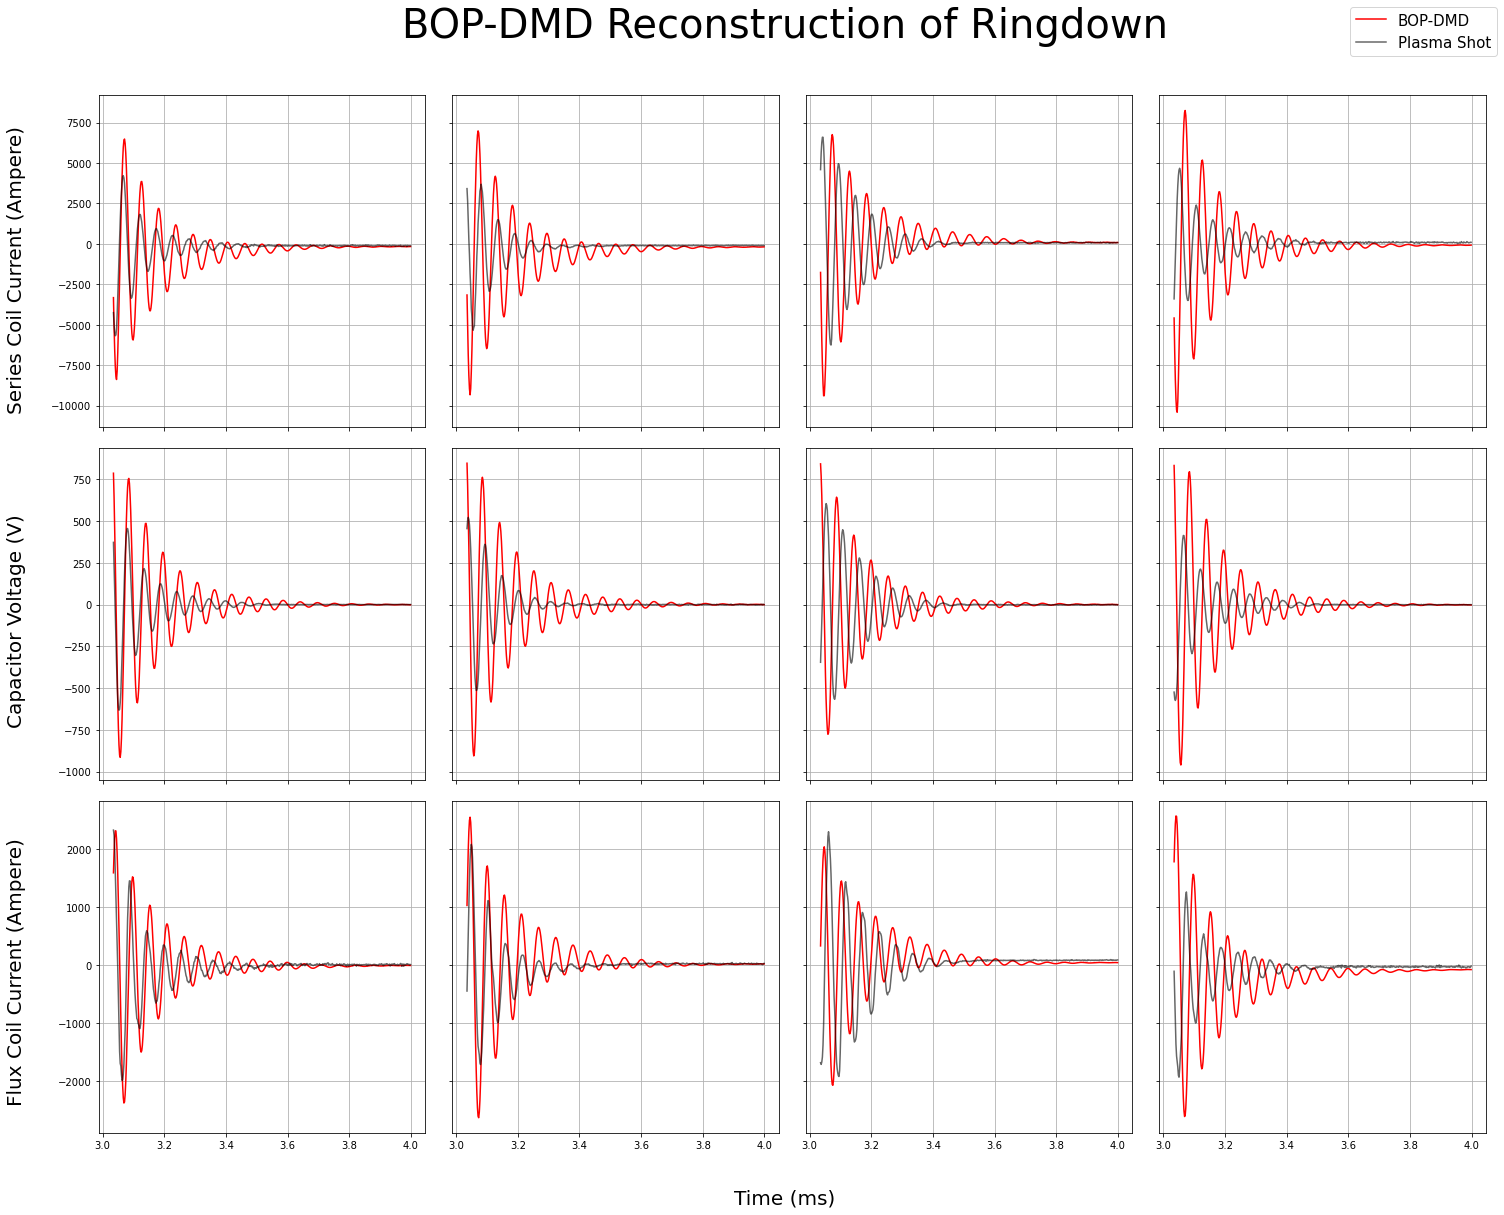

In [16]:
make_graph([xout_vacuum[1521::,:],flux_trajectory_list[0][1772::,:]],'BOP-DMD Reconstruction of Ringdown',['BOP-DMD','Plasma Shot'],
          impulse = True)


## In the cells below we try to formulate this problem as finding the smallest matrix that can be added to the vacuum DMD model to get a good plasma model

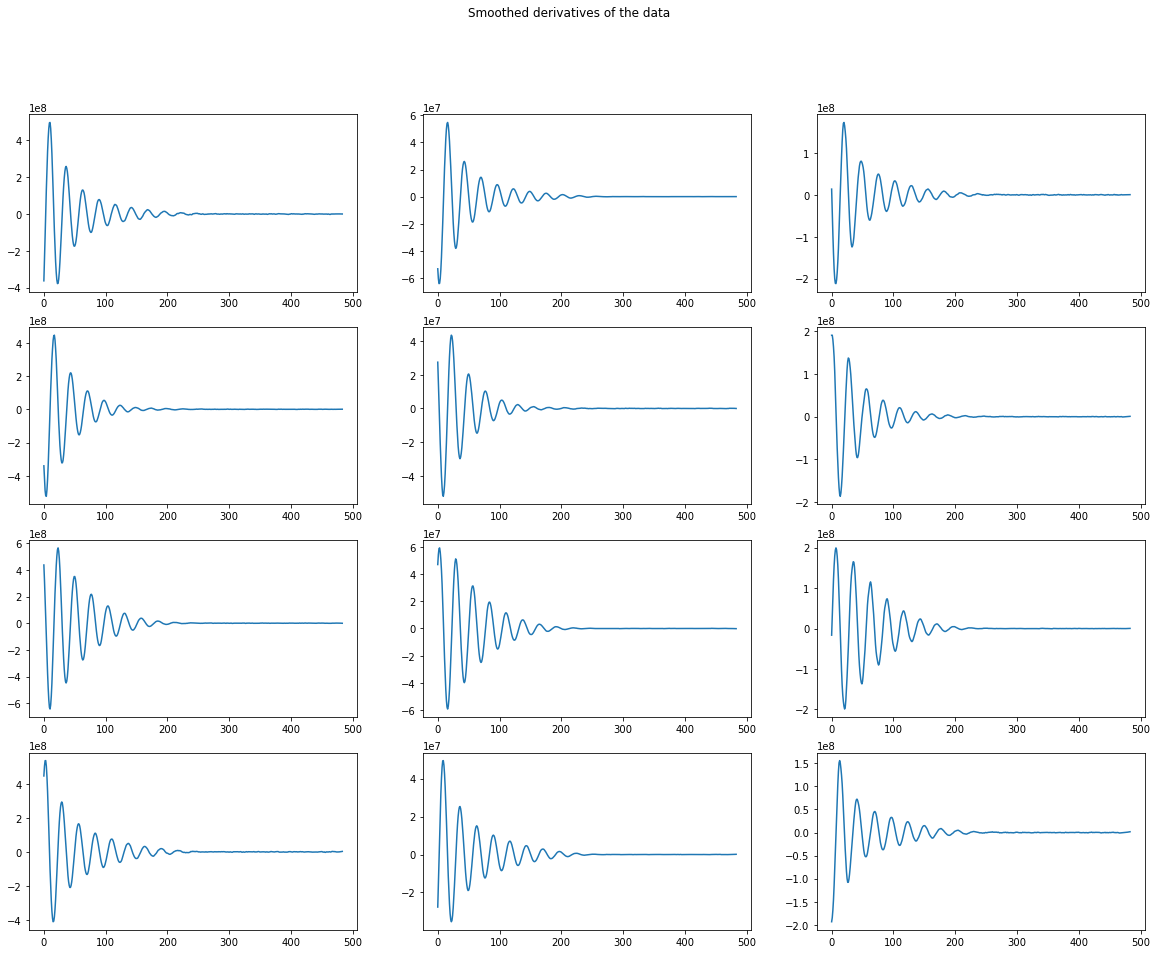

In [17]:
sfd = ps.differentiation.SmoothedFiniteDifference(smoother_kws={'window_length': 23}) #smooth out derivative

flux_plasma_derivative = sfd._differentiate(flux_trajectory_list[0][251::,:],experiment_time[251::]) #differentiate flux circuit
#trajectories


bop_A_vacuum_aug = np.vstack((bop_A_vacuum,np.zeros((1,12)))) #augment Vacuum DMD fit to have an extra row and col
bop_A_vacuum_aug = np.hstack( (bop_A_vacuum_aug, (np.zeros((13,1))) ) ) 
B_aug = np.vstack((B,np.zeros((1,4)))) #augment B matrix to have an extra row
C_aug = np.hstack((C,np.zeros((4,1)))) #Augment C matrix to have an extra col


x_dot = flux_plasma_derivative[1521:,:].T
x = flux_trajectory_list[0][1772::,0:13].T
u = flux_inputs_list[0][1772::,:].T


plt.figure(figsize = (20,15))
plt.suptitle('Smoothed derivatives of the data')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(flux_plasma_derivative[1521::,i])
    

In [18]:
def obj1(E_flat,hyper): #First objective function to determine the matrix that should be added
    E_flat = E_flat
    E = E_flat.reshape(13,13)

#     print(np.shape(E_flat))
    loss = hyper*np.linalg.norm(E) + np.mean( (x_dot - B_aug@(u) - 
    (bop_A_vacuum_aug+E)@(x) )**2 )
    return (loss)

def obj2(hyper): #Second objective function to determine the value of the hyperparamter that weights how small we make the 
                # Frobenius norm of the matrix
    init_guess = np.random.uniform(-1,1,(13,13))
    res = scipy.optimize.minimize(obj1,init_guess,args = (hyper,))
    return obj1(res.x,hyper=hyper)

# obj = l*np.linalg.norm(E.flatten(),2) + np.mean( (x_dot - B_aug@(u) - 
# (bop_A_vacuum_aug+E)@(x) )**2 )



hyper_list = np.linspace(2e9,4e9,10000) #List of values to search over. If the weight is too small, the dynamics become unstable
                                            # When the matrix is added

losses = []
# 
for i in range(len(hyper_list)):
    losses.append(obj1(np.random.uniform(-1,1,(13,13)),hyper_list[i]))
    
print(np.argmin(losses))

print(hyper_list[np.argmin(losses)])

res = scipy.optimize.minimize(obj1,np.random.uniform(-1,1,(13,13)),hyper_list[np.argmin(losses)])

6353
3270727072.7072706


C:\Users\ducks\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:579: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\Users\ducks\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


In [19]:
# res = prob.solve(verbose = True)

# print(res)

print(np.linalg.norm(res.x))

341571.7946827664


In [20]:


pert_A = bop_A_vacuum_aug + res.x.reshape(13,13)

#Ratio of vacuum model to matrix being added to correct the dynamics
print(np.linalg.norm(bop_A_vacuum_aug)/ np.linalg.norm( (res.x.reshape(13,13)) ))
#Difference between the 2 matrices
print(np.linalg.norm(pert_A.T - bop_A_vacuum_aug))

2.7143676785027506
1305150.8112752952


## It does a terrible job! Added matrix corrupts the stability of the underlying DMD model

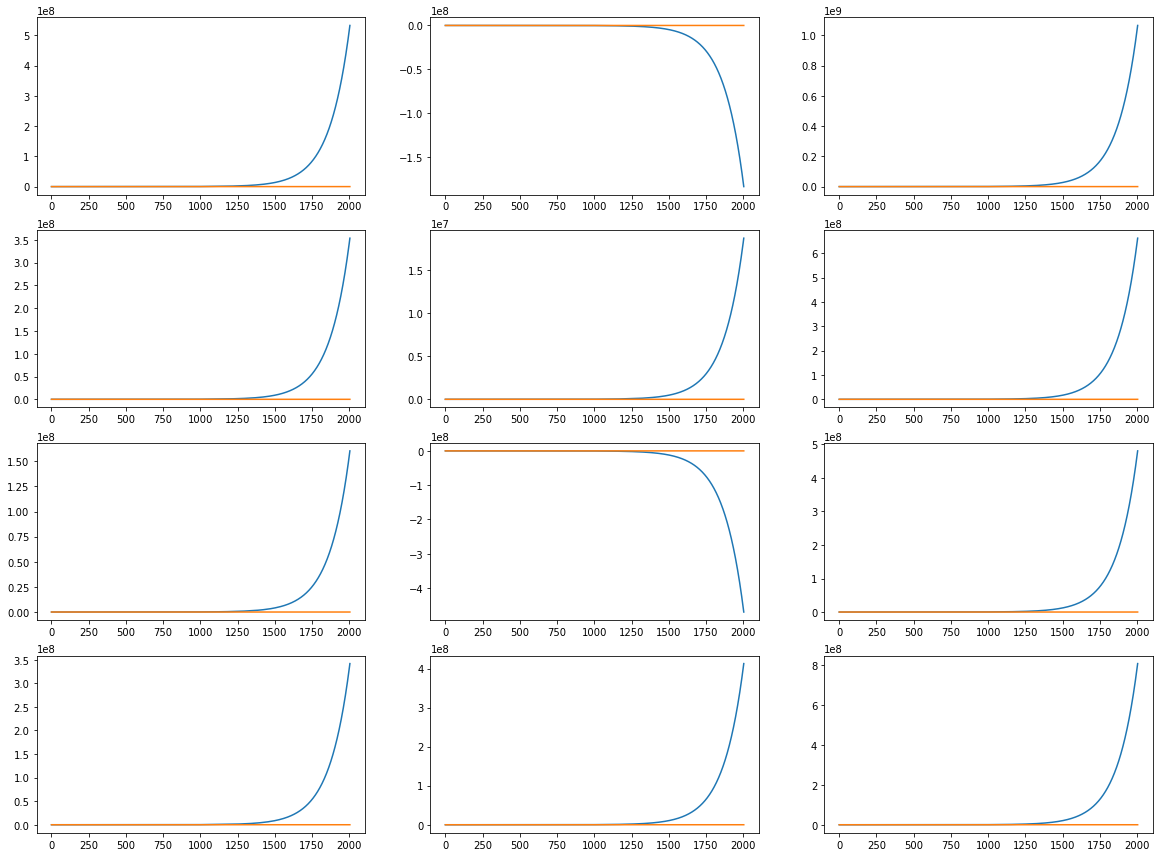

In [21]:
tout,yout,xout_pert = lsim((pert_A,B_aug,C_aug,D),flux_inputs_list[0][251::,:],experiment_time[251::])

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_pert[:,i]))
#     plt.plot(flux_trajectory_list[0][251::,i])
    plt.plot(np.real(xout_vacuum[:,i]))

## DMD on the residual between the BOP-DMD vacuum model and the plasma shot

In [22]:
xout_residual = np.real(xout_vacuum[:,:]) - flux_trajectory_list[0][251::,0:12]
print(len(xout_residual))
print(len(flux_inputs_list[0][1772::,:]))
Atilde_residual_list = []
bop_residual_obj_list = []
xout_residual_list = []
for i in range(40):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 30,
        training_set = xout_residual[1521::,:].T, #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = flux_inputs_list[0][1772::,:],
        test_voltage = flux_inputs_list[0][251::,:],
        train_time = experiment_time[1772::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,#np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = True,
        noise_level = 0,
        evaluate = True)
#     print(i)
    Atilde_residual_list.append(Atilde)
    bop_residual_obj_list.append(bop_obj)
    xout_residual_list.append(xout)

2005
484


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))


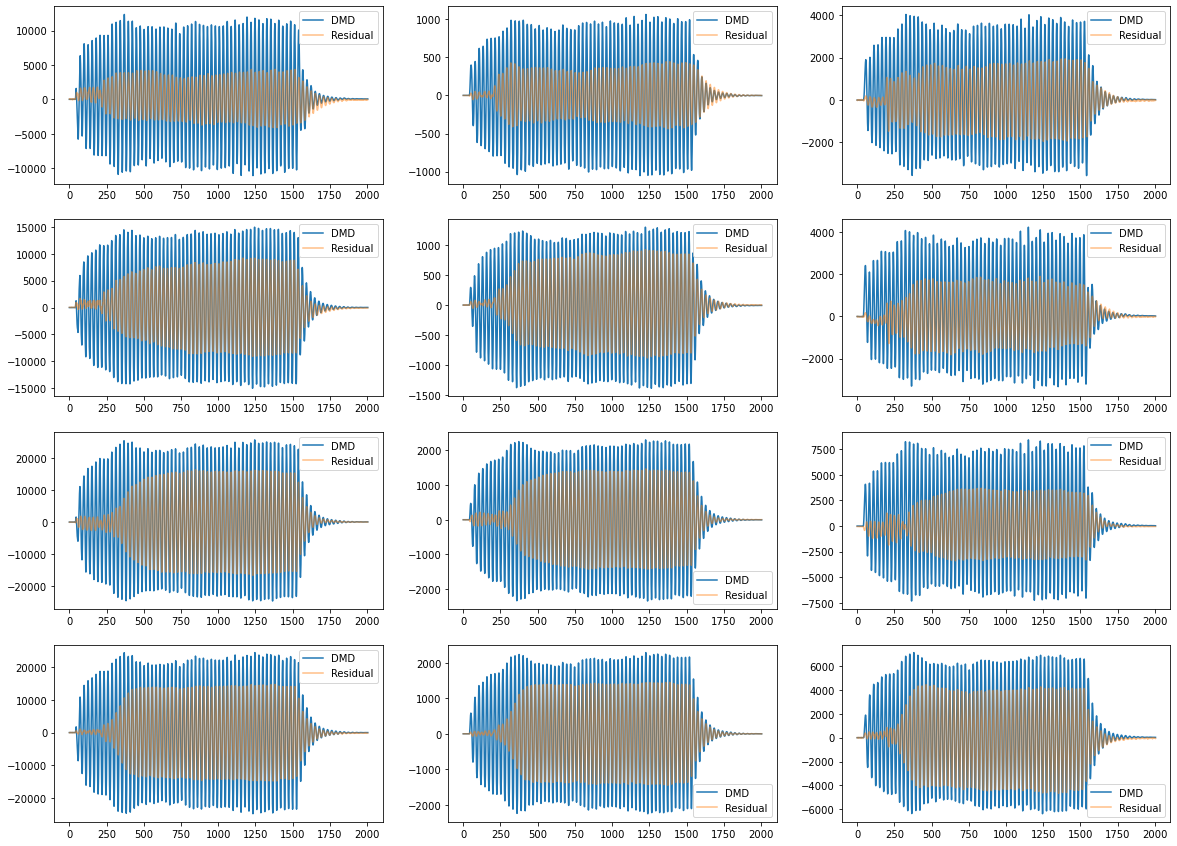

In [23]:
num = 3

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_residual_list[num][:,i]))
    plt.plot(xout_residual[:,i],alpha = .5)
    
    plt.legend(['DMD','Residual'])

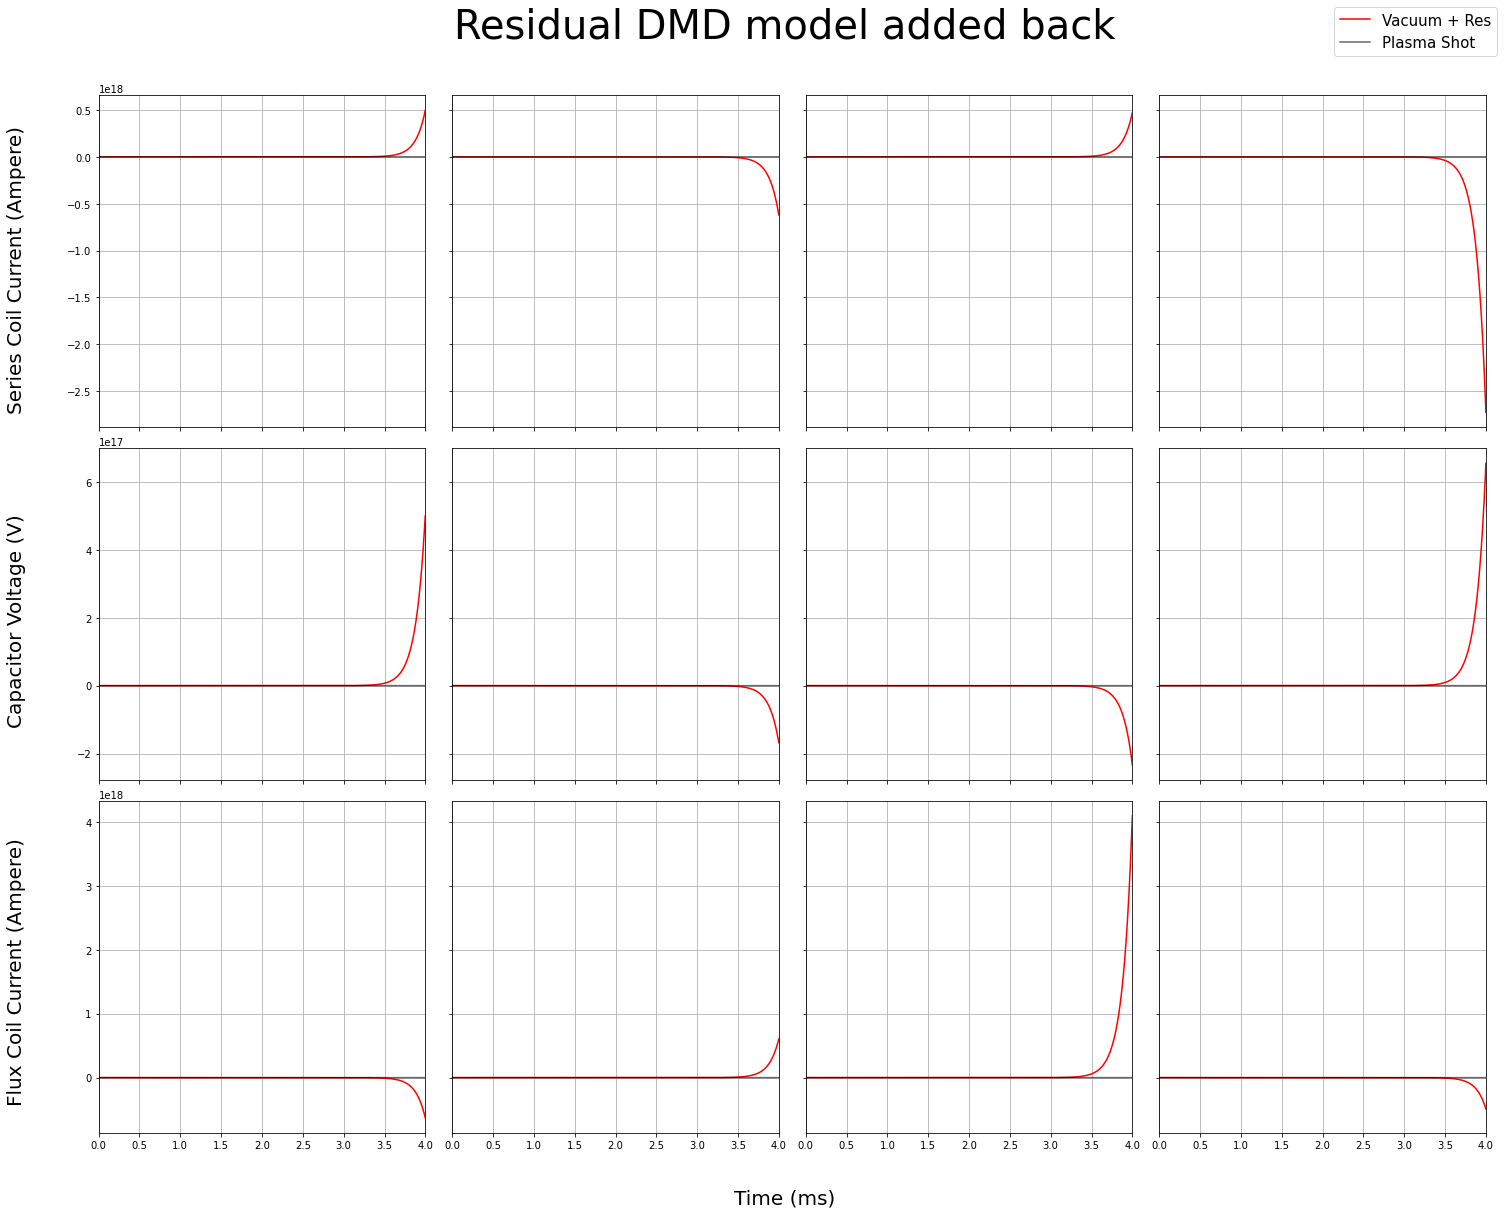

In [24]:

res_A = bop_A_vacuum + Atilde_residual_list[num] #+ 600*np.eye(12)

    
tout,yout,xout = lsim((res_A,B,C,D),flux_inputs_list[0][251::,:],experiment_time[251::])

make_graph([np.real(xout),flux_trajectory_list[0][251::,:]],'Residual DMD model added back',['Vacuum + Res','Plasma Shot'],impulse = False)



# plt.figure(figsize = (20,15))
# plt.suptitle('Adding the model of the residual back to the vacuum model from BOP-DMD ')
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(np.real(xout[:,i]))
#     plt.plot(flux_trajectory_list[0][251::,i])
#     plt.legend(['Vacuum DMD','Plasma Shot'])
#     plt.grid()

In [44]:
df_1 = pd.DataFrame(A)
df_2 = pd.DataFrame(A_plasma)
print(np.max(A))
print(np.max(A_plasma))
print(np.max(bop_A_vacuum))

516593.9389511707
1008605.5816790415
(119040.05014627213-2.183035533279389j)


(13, 13)


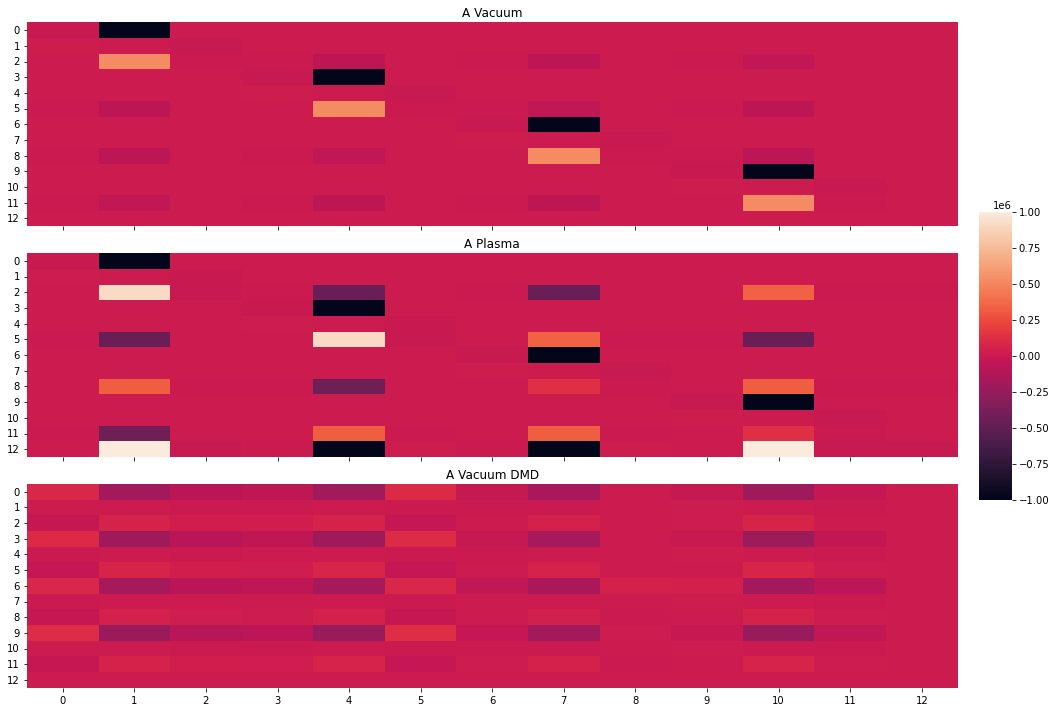

In [68]:
# df = pd.DataFrame(np.random.random((10,10,)))
A_aug = np.zeros(np.shape(bop_A_vacuum_aug))
print(np.shape(A_aug))
A_aug[0:12,0:12] = A
vals = [A_aug,A_plasma,bop_A_vacuum_aug.real]
fig, axn = plt.subplots(3, 1,figsize = (15,10),sharex = True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
# (figsize = (20,15))
titles = ['A Vacuum','A Plasma','A Vacuum DMD']
for i, ax in enumerate(axn.flat):
    sns.heatmap(data = vals[i], ax=ax,
                cbar=i == 0,
                cbar_ax=None if i else cbar_ax,vmin = -1e6, vmax = 1e6)
    ax.title.set_text(titles[i])
    sns.color_palette("Dark2", as_cmap=True)
fig.tight_layout(rect=[0, 0, .9, 1])

In [ ]:
# plt.scatter(np.linalg.eigvals(Atilde_residual_list[3]).real,np.linalg.eigvals(Atilde_residual_list[3]).imag)
plt.figure(figsize = (15,15))
plt.scatter(np.linalg.eigvals(bop_A_vacuum).real,np.linalg.eigvals(bop_A_vacuum).imag)
plt.scatter(np.linalg.eigvals(A_plasma).real,np.linalg.eigvals(A_plasma).imag,marker = '*',s = 160)
plt.scatter(np.linalg.eigvals(A).real,np.linalg.eigvals(A).imag,s = 40)
plt.xlim(right = -100)
plt.grid()
plt.xlabel('Real',fontsize = 15)
plt.ylabel('Imaginary',fontsize = 15)
plt.legend(['DMD','Analytic Plasma','Analytic Vacuum'])

## Can we model this system as the vacuum model being acted upon by some unitary matrix that rotates the eigenvalues and eigenvectors of the system? This will preserve stability by construction if we can also force that this unitary matrix is close to the identity. 

In [ ]:
U = cp.Variable((12,12))
x_dot = flux_plasma_derivative[1521:,0:12].T
x = flux_trajectory_list[0][1772::,0:12].T
u = flux_inputs_list[0][1772::,:].T
# cost = (1/(len(x)))*cp.sum_squares(x_dot - U@bop_A_vacuum@x)

# I = np.eye(12)

# prob = cp.Problem(cp.Minimize(cost),[U@cp.conj(U).T == I])

# prob.solve(verbose = True)

# Unitary,sca = scipy.linalg.orthogonal_procrustes((bop_A_vacuum@x).T,x_dot.T)

# A_pro = (bop_A_vacuum@x)
# B_pro = x_dot


def obj_unitary(V,l = 100):
    V_hat = V.reshape(12,12)
#     print(V_hat)
    loss = np.linalg.norm(x_dot - V_hat@bop_A_vacuum@x)**2 #+ l*np.linalg.norm(V_hat - np.eye(12))

In [ ]:

# scipy.linalg.orthogonal_procrustes?
np.random.uniform(0,1,(12,12))
V_hat = np.random.uniform(0,1,(12,12))
np.linalg.norm(x_dot - V_hat@bop_A_vacuum@x)**2
# res = scipy.optimize.minimize(obj_unitary,np.random.uniform(0,1,(12,12)))

In [ ]:
print(np.shape(res.x))

In [ ]:
vals,vecs = np.linalg.eig(Unitary)
vals[:].real = -1
Unitary_tilde = vecs@np.diag(vals)@vecs.T

print(np.shape(Unitary_tilde))

tout,yout,xout_unitary = lsim((bop_A_vacuum@Unitary_tilde,B,C,D),flux_inputs_list[0][251::,:],experiment_time[251::])

print((vals))

print(np.linalg.eigvals(bop_A_vacuum@Unitary_tilde).real)


plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_unitary[:,i].real)

In [ ]:
# M = B_pro@A_pro.T

# U,S,Vt = np.linalg.svd(M)

# print(np.shape(U@Vt))

# # np.linalg.eigvals(U@Vt@bop_A_vacuum).real

# sigma_last = np.linalg.det(U@Vt) + 1

# s_prime = np.ones(len(S))

# s_prime[-1] = sigma_last

# R = U@np.diag(s_prime)@Vt

